#Brain Tumor Detection

Importing the necessary libraries

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Image Preprocessing Libraries
import cv2
import imutils
from keras.preprocessing.image import ImageDataGenerator
# Model Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# Metrics Libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

Downloading Dataset from Kaggle

In [ ]:
'''
!pip install -q kaggle
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir data
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p data
'''

In [3]:
!unzip /content/data/brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_dataset

Archive:  /content/data/brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_

In [4]:
!rm -rf brain_tumor_dataset/brain_tumor_dataset

Building the model

In [5]:
# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 50

In [ ]:
mobile = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
for layer in mobile.layers[20:]:
      layer.trainable = True

In [7]:
model = Sequential()
model.add(mobile)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


Preprocessing the data

In [9]:
def crop_img(img):
    """
    Removes the excess part of the image and only keeps the brain image 
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding and Denoising the image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # Denoising using a series of erosion and dilation
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    thresh = np.uint8(thresh)
    # Finding and selecting the largest contour in the image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Finding the extreme points of the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Cropping the image
    img_cropped = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
    
    #Resizing Image
    img_final = cv2.resize(np.array(img_cropped), (IMG_SIZE, IMG_SIZE))
    
    return img_final

In [10]:

es = EarlyStopping(patience=7)
datagen = ImageDataGenerator(rescale = 1./255,
                             validation_split = 0.1, 
                             preprocessing_function=crop_img)

train_set = datagen.flow_from_directory('/content/brain_tumor_dataset',
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE,
                                        subset='training',
                                        class_mode = 'binary')

validation_set = datagen.flow_from_directory('/content/brain_tumor_dataset',
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size = BATCH_SIZE,
                                            subset='validation',
                                            class_mode = 'binary',
                                            shuffle=False)

Found 229 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


Fitting the Model on train and validation data

In [11]:
history = model.fit(train_set,
                    steps_per_epoch = train_set.n//train_set.batch_size,
                    epochs = EPOCHS,
                    validation_data = validation_set,
                    validation_steps = validation_set.n//validation_set.batch_size,
                    verbose = 2,
                    callbacks=[es])

Epoch 1/50
28/28 - 3s - loss: 0.6379 - accuracy: 0.6244 - val_loss: 0.7995 - val_accuracy: 0.4167
Epoch 2/50
28/28 - 2s - loss: 0.2607 - accuracy: 0.9186 - val_loss: 1.0918 - val_accuracy: 0.4167
Epoch 3/50
28/28 - 2s - loss: 0.2029 - accuracy: 0.9186 - val_loss: 1.4507 - val_accuracy: 0.4167
Epoch 4/50
28/28 - 2s - loss: 0.1221 - accuracy: 0.9683 - val_loss: 1.1173 - val_accuracy: 0.5417
Epoch 5/50
28/28 - 2s - loss: 0.0733 - accuracy: 0.9819 - val_loss: 1.3652 - val_accuracy: 0.5000
Epoch 6/50
28/28 - 2s - loss: 0.0399 - accuracy: 0.9955 - val_loss: 1.2726 - val_accuracy: 0.5000
Epoch 7/50
28/28 - 2s - loss: 0.0367 - accuracy: 0.9910 - val_loss: 0.8513 - val_accuracy: 0.7083
Epoch 8/50
28/28 - 2s - loss: 0.0763 - accuracy: 0.9729 - val_loss: 0.7696 - val_accuracy: 0.7500
Epoch 9/50
28/28 - 2s - loss: 0.0286 - accuracy: 0.9910 - val_loss: 0.5993 - val_accuracy: 0.7500
Epoch 10/50
28/28 - 2s - loss: 0.0695 - accuracy: 0.9729 - val_loss: 0.6115 - val_accuracy: 0.7083
Epoch 11/50
28/28 -

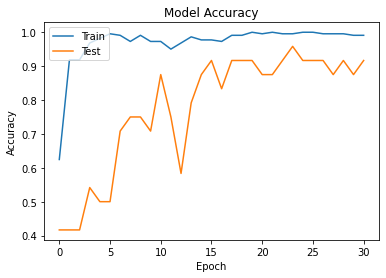

In [12]:
# Plotting model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

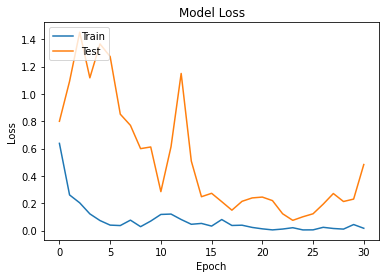

In [13]:
# Plotting model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Calculating and plotting the model metrics

In [14]:
y_test = validation_set.labels

In [ ]:
y_pred = model.predict_classes(validation_set)
y_pred = y_pred.reshape(len(y_pred),)

In [16]:
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(cohen_kappa_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.8823529411764706
1.0
0.9375
0.813953488372093
0.8888888888888888


In [18]:
model.save('brain_tumor_detection_mobile.h5')